In [67]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from PIL import ImageFile
from PIL import Image

In [58]:
# %pip install pillow
# !pip install pillow
from PIL import ImageFile

In [45]:
# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Directories for train, validation, and test sets
train_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\train"
val_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\val"
test_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test"

In [46]:
# Data augmentations and transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [47]:
# Loading datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['val'])

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
classes = os.listdir(train_dir)
print(f"Classes found: {len(classes)}")
print(classes)

Number of training samples: 9246
Number of validation samples: 829
Number of test samples: 506
Classes found: 2
['fractured', 'not fractured']


In [48]:
# Load a pretrained ResNet model and modify for binary classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a pretrained ResNet18 model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze the pretrained layers

# Modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

model = model.to(device)

c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [50]:
# Step 7: EarlyStopping Class to stop training when validation loss stops improving
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [51]:
# Step 8: Define the training function with scheduler and early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=3):
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images)
                loss = criterion(outputs.view(-1), labels)
                val_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}")

        # Check early stopping conditions
        early_stopping(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

In [27]:
# Step 9: Train the model with early stopping and scheduler
train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=3)

c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 0.5017, Val Loss: 0.4708
Epoch [2/10], Train Loss: 0.3858, Val Loss: 0.4004
Epoch [3/10], Train Loss: 0.3339, Val Loss: 0.4058
Epoch [4/10], Train Loss: 0.3138, Val Loss: 0.3845
Epoch [5/10], Train Loss: 0.2647, Val Loss: 0.3412
Epoch [6/10], Train Loss: 0.2225, Val Loss: 0.3683
Epoch [7/10], Train Loss: 0.2092, Val Loss: 0.3400
Epoch [8/10], Train Loss: 0.2034, Val Loss: 0.3363
Epoch [9/10], Train Loss: 0.1938, Val Loss: 0.3332
Epoch [10/10], Train Loss: 0.2008, Val Loss: 0.3239


In [52]:
# Step 10: Save the trained model
model_save_path = "fracture_classification_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to fracture_classification_model.pth


In [53]:
# Step 11: Load the model for inference
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model(model, model_save_path)

C:\Users\daans\AppData\Local\Temp\ipykernel_12060\229585333.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [54]:
# Step 12: Define a prediction function for new images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    
    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Sigmoid to get probability
        label = "Fractured" if prob > 0.5 else "Not Fractured"
    
    return label, prob

Prediction: Fractured, Probability: 0.6118


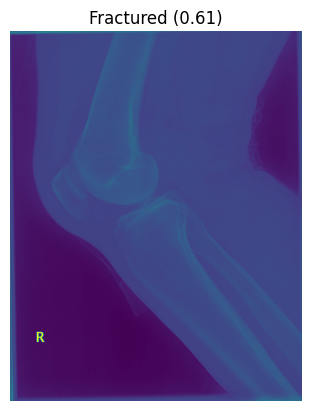

In [71]:
# Step 13: (Optional) Visualize predictions
def visualize_prediction(image_path, model, transform):
    label, prob = predict_image(image_path, model, transform)
    image = Image.open(image_path)
    
    plt.imshow(image)
    plt.title(f"{label} ({prob:.2f})")
    plt.axis("off")
    plt.show()

# Example usage for prediction and visualization
example_image_path = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test\fractured\001.png"  # Replace with a test image path

label, prob = predict_image(example_image_path, model, transform)
print(f"Prediction: {label}, Probability: {prob:.4f}")

# Visualize the prediction
visualize_prediction(example_image_path, model, transform)

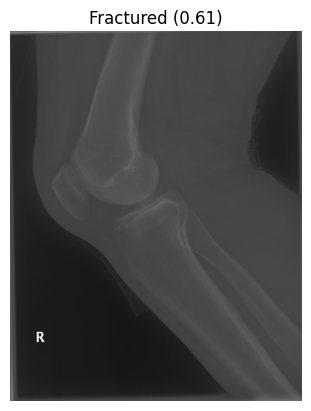

In [75]:
import requests
from io import BytesIO

# Step 1: Function to open an image from a URL or a local file
def open_image(image_input):
    if image_input.startswith("http://") or image_input.startswith("https://"):
        # It's a URL
        response = requests.get(image_input)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        # It's a local file path
        image = Image.open(image_input).convert("RGB")
    return image

# Step 2: Function to predict fracture status for a given image
def predict_image(image_input, model, transform):
    image = open_image(image_input)  # Open image from URL or local path
    image_transformed = transform(image).unsqueeze(0)  # Add batch dimension
    image_transformed = image_transformed.to(device)
    
    with torch.no_grad():
        output = model(image_transformed)
        prob = torch.sigmoid(output).item()  # Get the probability
        label = "Fractured" if prob > 0.5 else "Not Fractured"
    
    return label, prob

# Step 3: Function to visualize the prediction
def visualize_prediction(image_input, model, transform):
    label, prob = predict_image(image_input, model, transform)
    image = open_image(image_input)  # Open image again for visualization
    
    plt.imshow(image)
    plt.title(f"{label} ({prob:.2f})")
    plt.axis("off")
    plt.show()

# Example usage
example_image_input = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test\fractured\001.png"  # local path
# example_image_input = "https://healthcare.utah.edu/sites/g/files/zrelqx136/files/migrate_images/0_wny3n8ot.jpg"  # URL
# example_image_input = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test\fractured\001.png"  # Local image path
visualize_prediction(example_image_input, model, transform)
